## Project 1.3 - Results and Comparison

Group: Emmy Noether

Students: Janik Rausch (628334), Camilo Tello Breuer (633291), Ida Wöstheinrich (628428)

In [1]:
using LinearAlgebra,Random,Printf,FFTW,JLD,Plots,LaTeXStrings,Colors
include("1.2_Ground_state.jl"); include("1.3_Evolution.jl")

simulate_2D

If you want to see the documentation of the functions call `@doc function_name` and choose markdown as presentation output.

In [2]:
@doc println

```
println([io::IO], xs...)
```

Print (using [`print`](@ref)) `xs` to `io` followed by a newline. If `io` is not supplied, prints to the default output stream [`stdout`](@ref).

See also [`printstyled`](@ref) to add colors etc.

# Examples

```jldoctest
julia> println("Hello, world")
Hello, world

julia> io = IOBuffer();

julia> println(io, "Hello", ',', " world.")

julia> String(take!(io))
"Hello, world.\n"
```


**1D Evolution**

First we run the 1D evolution algorithm with a Gaussian wavepacket localized in one of the potential minima as the initial state. The values of $N$ and $\epsilon$ were chosen based on the infinite-volume/continuum limit extrapolations in the previous subproject to keep discretization/boundary effects small.

Energy expectation: 0.8807562964828238
Potential barrier: 2.5


Plots.AnimatedGif("c:\\Users\\janik\\OneDrive\\Desktop\\Uni\\Master\\Computational Physics II\\Project 1\\1.3 - Dynamics\\crank-nicolson.gif")
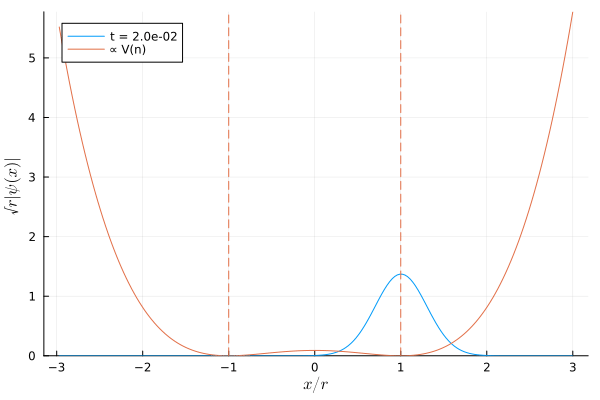

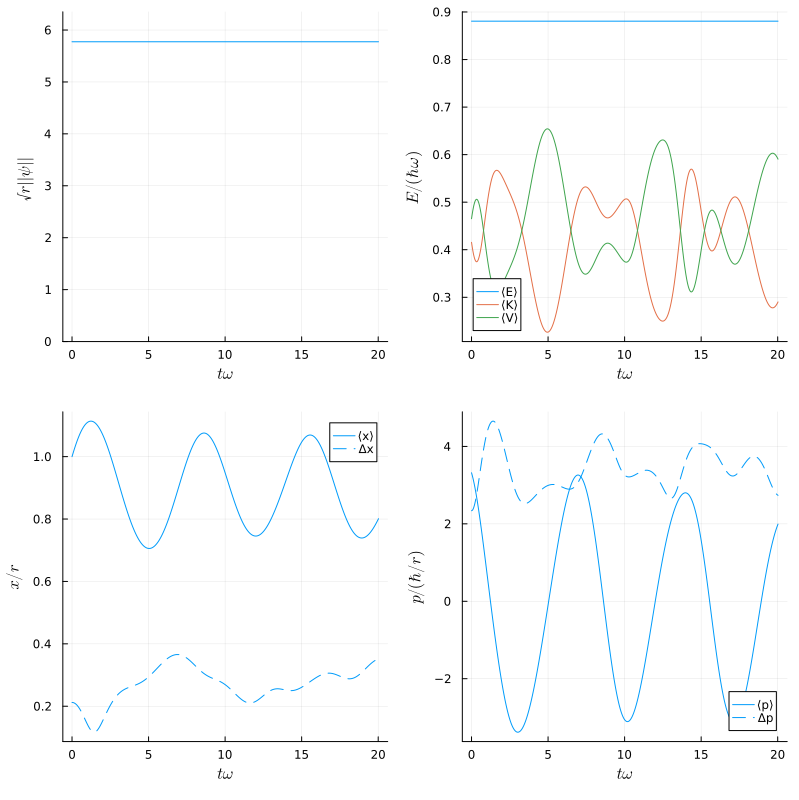

┌ Info: Saved animation to c:\Users\janik\OneDrive\Desktop\Uni\Master\Computational Physics II\Project 1\1.3 - Dynamics\crank-nicolson.gif
└ @ Plots C:\Users\janik\.julia\packages\Plots\sxUvK\src\animation.jl:156


In [7]:
N = 200
T, τ = 20, 0.02
μ, ϵ = 20, 0.03

fps = 20; gif_length = 10

m, k = (1/ϵ,), (0.1,)
σ = 10

ψ_0 = wave_packet(lattice(N, 1), m, σ, k)

println("Energy expectation: ", energy_expectation(ψ_0, μ, ϵ)[1])
println("Potential barrier: ", μ/8)

simulate_1D(N, μ, ϵ, T, τ, ψ_0, "strang-splitting", fps, gif_length)

If the `euler integrator` is used, the norm of the wavefunction quickly blows up to infinity with the chosen step size. The other two integrators appear to conserve both the norm and the total energy to high accuracy though, and the tunnel effect is clearly visible.

As a sanity check, we run the code starting from the ground state:

Plots.AnimatedGif("c:\\Users\\janik\\OneDrive\\Desktop\\Uni\\Master\\Computational Physics II\\Project 1\\1.3 - Dynamics\\strang-splitting.gif")
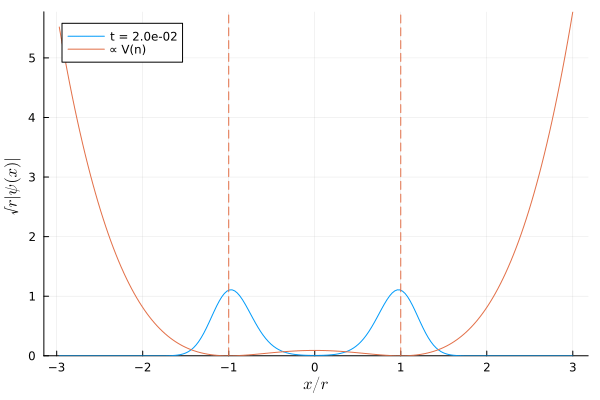

┌ Info: Saved animation to c:\Users\janik\OneDrive\Desktop\Uni\Master\Computational Physics II\Project 1\1.3 - Dynamics\strang-splitting.gif
└ @ Plots C:\Users\janik\.julia\packages\Plots\sxUvK\src\animation.jl:156


In [62]:
N = 200
T, τ = 20, 0.02
μ, ϵ = 20, 0.03

fps = 20; gif_length = 10

ψ_0 = ground_state((N,), μ, ϵ, 1e-4, 10000, 1e-4, 100000; init = fill(1, (N,)), verbose = false)[2]

simulate_1D(N, μ, ϵ, T, τ, ψ_0, "crank-nicolson", fps, gif_length; observe = false)

As expected, the absolute value of the wavefunction doesn't change since it is an eigenstate of the Hamiltonian (except when using the `euler integrator`).

**2D Evolution**

Plots.AnimatedGif("c:\\Users\\janik\\OneDrive\\Desktop\\Uni\\Master\\Computational Physics II\\Project 1\\1.3 - Dynamics\\strang-splitting_2D.gif")
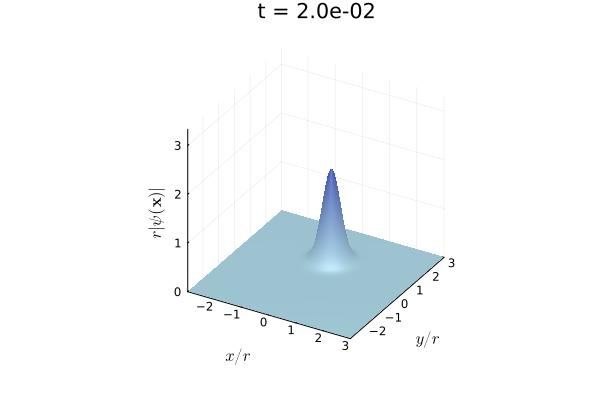

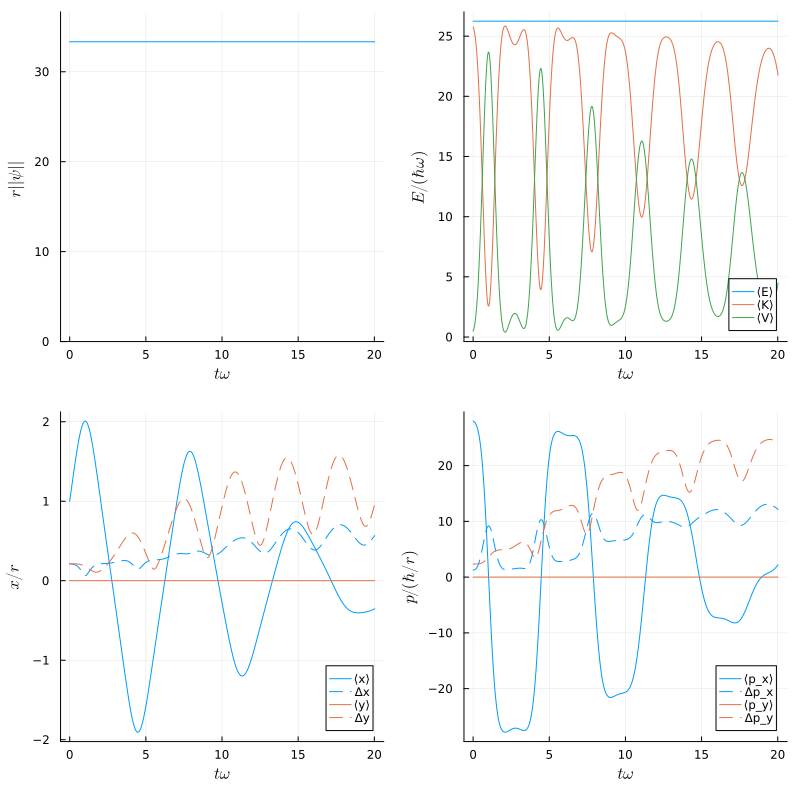

┌ Info: Saved animation to c:\Users\janik\OneDrive\Desktop\Uni\Master\Computational Physics II\Project 1\1.3 - Dynamics\strang-splitting_2D.gif
└ @ Plots C:\Users\janik\.julia\packages\Plots\sxUvK\src\animation.jl:156


In [3]:
N = 200
T, τ = 20, 0.02
μ, ϵ = 20, 0.03

fps = 20; gif_length = 10

m, k = (1/ϵ,0), (1,0)
σ = 10

ψ_0 = wave_packet(lattice(N, 2), m, σ, k)

simulate_2D(N, μ, ϵ, T, τ, ψ_0, "strang-splitting", fps, gif_length)

In the 2D case, it becomes clear that the Strang-splitting integrator is much quicker than `crank-nicolson` due to the efficiency of the FFT algorithm. Again, both appear to be norm- and energy-conserving.

**Comparison (1D)**

First we do a qualitative comparison of the wavefunction dynamics produced by the three integrators.

In [31]:
function compare_anim(N, μ, ϵ, T, τ, ψ_0, fps, gif_length; tol_cg::Number=1e-10, maxiters_cg::Int=10000)
    @assert(T > 0, "T = " * string(T) * " must be positive")
    @assert(fps > 0, "fps = " * string(fps) * " must be positive")
    @assert(gif_length > 0, "gif_length = " * string(gif_length) * " must be positive")
    @assert(round(Int, 1/(gif_length*fps) * T/τ) > 0, "increase T or decrease gif_length, fps and/or τ")
    
    n = lattice(N, 1); V = potential(μ, ϵ, n)
    ψ_e, ψ_cn, ψ_ss = copy(ψ_0), copy(ψ_0), copy(ψ_0)
    t = 0

    P = plan_fft(ψ_0); P_inv = inv(P)
    
    anim = @animate while t < T
        ψ_e = euler(μ, ϵ, ψ_e, V, τ)
        ψ_cn = crank_nicolson(μ, ϵ, ψ_cn, V, τ, tol_cg, maxiters_cg)
        ψ_ss = strang_splitting(μ, ϵ, ψ_ss, V, τ, P, P_inv)
        t += τ
        plot(n*ϵ, abs.(ψ_e)./sqrt(ϵ), color = RGB(0, 0.75, 1.0), label = "Euler")
        plot!(n*ϵ, abs.(ψ_cn)./sqrt(ϵ), color = RGB(0.3, 0.375, 0.9), label = "Crank-Nicolson")
        plot!(n*ϵ, abs.(ψ_ss)./sqrt(ϵ), color = RGB(0.6, 0, 0.8), label = "Strang-Splitting")
        xlabel!(L"x/r"); ylabel!(L"√r|\psi\,(x)|")
        ylims!(0, 1/sqrt(ϵ))
        plot!(n*ϵ, V/max(V...)./sqrt(ϵ), color = 2, label = "∝ V(n)")
        vline!([-1, 1], color = 2, label = "", linestyle = :dash)
        fmt = Printf.Format("t = %.1e")
        title!(Printf.format(fmt, t))
    end every round(Int, 1/(gif_length*fps) * T/τ)
    
    display(gif(anim, "Compare_anim_ " * string(τ) * ".gif", fps = fps))
end

compare_anim (generic function with 1 method)

Plots.AnimatedGif("c:\\Users\\janik\\OneDrive\\Desktop\\Uni\\Master\\Computational Physics II\\Project 1\\1.3 - Dynamics\\Compare_anim_ 0.1.gif")
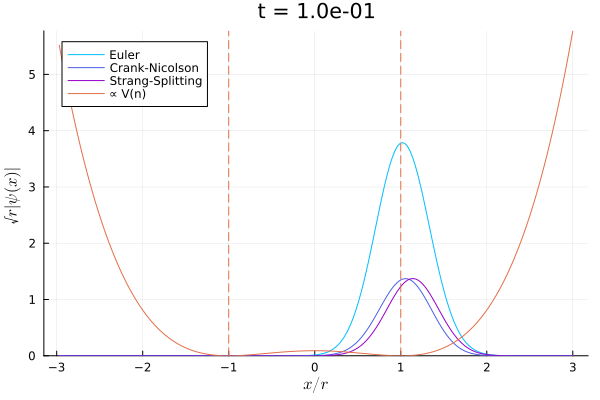

┌ Info: Saved animation to c:\Users\janik\OneDrive\Desktop\Uni\Master\Computational Physics II\Project 1\1.3 - Dynamics\Compare_anim_ 0.1.gif
└ @ Plots C:\Users\janik\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\janik\\OneDrive\\Desktop\\Uni\\Master\\Computational Physics II\\Project 1\\1.3 - Dynamics\\Compare_anim_ 0.001.gif")
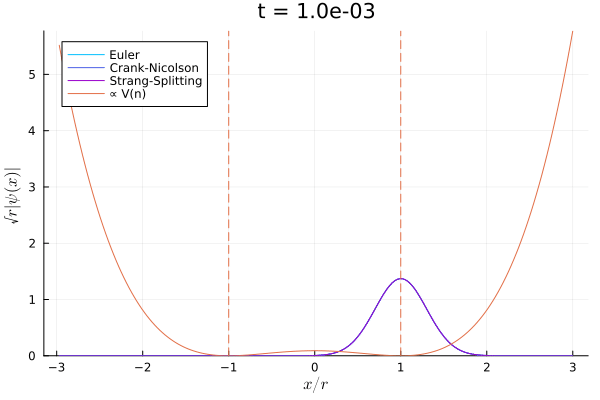

┌ Info: Saved animation to c:\Users\janik\OneDrive\Desktop\Uni\Master\Computational Physics II\Project 1\1.3 - Dynamics\Compare_anim_ 0.001.gif
└ @ Plots C:\Users\janik\.julia\packages\Plots\sxUvK\src\animation.jl:156


In [32]:
N = 200
T = 5
μ, ϵ = 20, 0.03

fps = 15; gif_length = 5

m, k = (1/ϵ,), (1,)
σ = 10

ψ_0 = wave_packet(lattice(N, 1), m, σ, k)

compare_anim(N, μ, ϵ, T, 0.1, ψ_0, fps, gif_length)
compare_anim(N, μ, ϵ, T, 0.001, ψ_0, fps, gif_length)

With a step size of $\hat{\tau}=0.1$, all three integrators produce very different results. For $\hat{\tau}=0.001$, the `euler integrator` still diverges, but the other two integrators agree very closely.

We also compare the end results of the different integrators for a fixed time interval $T$, while decreasing the time step $\tau$:

┌ Info: Saved animation to c:\Users\janik\OneDrive\Desktop\Uni\Master\Computational Physics II\Project 1\1.3 - Dynamics\cool_limit.gif
└ @ Plots C:\Users\janik\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\janik\\OneDrive\\Desktop\\Uni\\Master\\Computational Physics II\\Project 1\\1.3 - Dynamics\\cool_limit.gif")
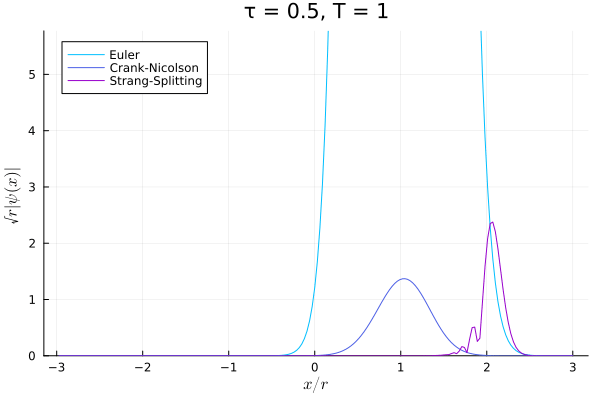

In [37]:
N = 200
μ, ϵ = 20, 0.03
T = 1

m, k = (1/ϵ,), (1,)
σ = 10

ψ_0 = wave_packet(lattice(N, 1), m, σ, k)
P = plan_fft(ψ_0); P_inv = inv(P)

n = lattice(N, 1)
V = potential(μ, ϵ, n)

τ_array = [(1/2)^k for k in 1:15]

anim = @animate for τ in τ_array
    ψ_e, ψ_cn, ψ_ss = copy(ψ_0), copy(ψ_0), copy(ψ_0)
    t = 0
    
    while t < T
        ψ_e = euler(μ, ϵ, ψ_e, V, τ)
        ψ_cn = crank_nicolson(μ, ϵ, ψ_cn, V, τ, 1e-10, 10000)
        ψ_ss = strang_splitting(μ, ϵ, ψ_ss, V, τ, P, P_inv)
        t += τ
    end

    p = plot(n*ϵ, abs.(ψ_e)./sqrt(ϵ), color = RGB(0, 0.75, 1.0), label = "Euler", legend=:topleft)
    plot!(n*ϵ, abs.(ψ_cn)./sqrt(ϵ), color = RGB(0.3, 0.375, 0.9), label = "Crank-Nicolson")
    plot!(n*ϵ, abs.(ψ_ss)./sqrt(ϵ), color = RGB(0.6, 0, 0.8), label = "Strang-Splitting")
    xlabel!(L"x/r"); ylabel!(L"√r|\psi\,(x)|")
    ylims!(0, 1/sqrt(ϵ))
    title!("τ = " * string(round(τ, digits = 5)) * ", T = " * string(T))
end

gif(anim, "cool_limit.gif", fps = 5)

For sufficiently small $\hat{\tau}$, all integrators produce the same result. Clearly the `strang-splitting` integrator converges most quickly, followed by `crank-nicolson` and then `euler`.